Minimal STDP training on N-MNIST (PyTorch + tonic)
- Unsupervised STDP on a single LIF layer (fully connected)
- WTA competition
- Label assignment (winner neuron per class) for evaluation

This is designed to be *lightweight* and CPU-friendly. Adjust NUM_BATCHES, N_NEURONS, and N_TIME_BINS
based on your resources. It uses event frames (still spikes, binned in time) to keep implementation simple.

Requirements:
    pip install torch tonic numpy

Tip: If you have the dataset already, set ROOT to your local folder. Otherwise tonic will download it there.


In [113]:
from __future__ import annotations
import os
from dataclasses import dataclass
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import tonic
import tonic.transforms as tt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Config

In [114]:
class Config:
    root: str = os.path.expanduser("/Users/matteogiardina/Desktop/BEMACS 2/SNNs/BainsaSNNs/N-MNIST/n-mnist_data")
    batch_size: int = 64
    n_time_bins: int = 60           # number of temporal bins per sample (~5 ms each if sample ~300 ms)
    n_neurons: int = 512            # spiking units in the feature layer
    
    thr: float = 1.0                # firing threshold
    tau_mem: float = 20.0           # membrane time constant (ms)
    dt: float = 1.0                 # integration step (ms)
    
    eta_plus: float = 0.001          # STDP LTP rate
    eta_minus: float = 0.0007         # STDP LTD rate
    
    tau_pre: float = 20.0           # pre trace time constant (ms)
    tau_post: float = 20.0          # post trace time constant (ms)

    w_norm: float = 1.0             # L2 norm target per neuron (row-wise)
    w_clip: tuple[float, float] = (0.0, 1.0)  # clamp weights after updates
    
    inhibition: float = 3.0         # lateral inhibition strength (for soft competition)
    use_hard_wta: bool = False       # if True keep only the top-1 spike per sample at each timestep ------ WTA Winner Takes All
    device: str = "mps"             # set "cuda" if available
    num_batches: int = 200          # how many train batches to run (unsupervised phase)
    seed: int = 987

C = Config()
C.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# C.num_batches = 800 Lo settiamo in base alla lunghezza del dataset dopo aver loaded train_loader
# C.n_neurons = 512
# C.use_hard_wta = False

# Utils

In [115]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(C.seed)

def l2_row_normalize_(W: torch.Tensor, target_norm: float):
    # Normalize each row to given L2 norm
    norms = W.norm(p=2, dim=1, keepdim=True) + 1e-8
    W.mul_(target_norm / norms)

Dataset / Dataloaders (frames)

In [116]:
sensor_size = tonic.datasets.NMNIST.sensor_size

transform = tt.ToFrame(sensor_size=sensor_size, n_time_bins=C.n_time_bins)

train_ds = tonic.datasets.NMNIST(save_to=C.root, train=True, transform=transform)
test_ds  = tonic.datasets.NMNIST(save_to=C.root, train=False, transform=transform)

In [117]:
# cached_train = tonic.DiskCachedDataset(train_ds, cache_path = "./cache/mnist/train")
# cached_test  = tonic.DiskCachedDataset(test_ds,  cache_path = "./cache/mnist/train")

In [118]:
train_loader = DataLoader(train_ds, batch_size=C.batch_size,
                          shuffle=True, drop_last=True,
                          collate_fn=tonic.collation.PadTensors())

test_loader  = DataLoader(test_ds, batch_size=C.batch_size,
                          shuffle=False, drop_last=False,
                          collate_fn=tonic.collation.PadTensors())

Batch Shape: torch.Size([64, 60, 2, 34, 34])
Valore Massimo nel tensore: 7.0
Valore Medio (dovrebbe essere > 0): 0.029879208654165268
Numero totale di eventi (pixel attivi) nel batch: 265270.0


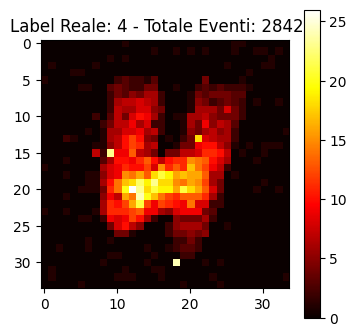

In [119]:
# Prendi un batch
frames, labels = next(iter(train_loader))
# frames shape: [Batch, Time, Channels, Height, Width]

print(f"Batch Shape: {frames.shape}")
print(f"Valore Massimo nel tensore: {frames.max().item()}")
print(f"Valore Medio (dovrebbe essere > 0): {frames.float().mean().item()}")
print(f"Numero totale di eventi (pixel attivi) nel batch: {frames.sum().item()}")

# Visualizza la somma temporale del primo campione (dovrebbe sembrare una cifra)
import matplotlib.pyplot as plt

sample_idx = 0
# Somma su Tempo (dim 1) e Canali (dim 2) -> [H, W]
image_sum = frames[sample_idx].sum(dim=0).sum(dim=0).cpu()

plt.figure(figsize=(4,4))
plt.imshow(image_sum, cmap='hot')
plt.title(f"Label Reale: {labels[sample_idx].item()} - Totale Eventi: {image_sum.sum().item()}")
plt.colorbar()
plt.show()

In [120]:
# Definisci quante epochs vuoi fare
N_EPOCHS = 2

# Aggiorna la configurazione ora che conosciamo la lunghezza del loader
C.num_batches = int(len(train_loader) * N_EPOCHS)

print(f"Configurazione aggiornata: Training per {N_EPOCHS} epochs.")
print(f"Totale batch da elaborare: {C.num_batches} --> {C.num_batches * C.batch_size} samples")

Configurazione aggiornata: Training per 2 epochs.
Totale batch da elaborare: 1874 --> 119936 samples


LIF + STDP Layer (fully connected)

In [121]:
# class LIF_STDP_Layer(nn.Module):
#     def __init__(self, n_in: int, n_out: int, cfg: Config):
#         super().__init__()
#         self.cfg = cfg
#         self.n_in, self.n_out = n_in, n_out
#         # Weight init: small positive random values encourage sparse selectivity
#         W = torch.rand(n_out, n_in) * 1.0
#         self.W = nn.Parameter(W)  # we will update in-place (no autograd)
#         self.register_buffer("theta", torch.ones(n_out) * cfg.thr) # buffer per la soglia adattiva
#         self.theta_plus = 0.002      # Di quanto aumenta la soglia dopo uno spike
#         self.theta_decay = 0.995   # Decadimento della soglia (molto lento)
#         self.register_buffer("v", torch.zeros(1, n_out))  # membrane per sample (we'll expand to batch)
#         # traces (global per pre/post; we aggregate across the batch each step)
#         self.register_buffer("x_pre", torch.zeros(n_in))
#         self.register_buffer("x_post", torch.zeros(n_out))

#     def reset_state(self, batch_size: int):
#         self.v = torch.zeros(batch_size, self.n_out, device=self.W.device)
    
#     @torch.no_grad()
#     def stdp_step_(self, pre_spk_b: torch.Tensor, post_spk_b: torch.Tensor):
#         """Apply pair-based STDP using *batch-aggregated* spikes.
#         pre_spk_b: [B, n_in] (0/1)
#         post_spk_b: [B, n_out] (0/1)
#         This uses population traces: x_pre (n_in), x_post (n_out).
#         """
#         cfg = self.cfg
#         # Decay traces
#         self.x_pre.mul_(math.exp(-cfg.dt / cfg.tau_pre))
#         self.x_post.mul_(math.exp(-cfg.dt / cfg.tau_post))

#         # Aggregate spikes over batch (sum) and binarize to {0,1} for stability
#         pre = (pre_spk_b.sum(dim=0) > 0).float()
#         post = (post_spk_b.sum(dim=0) > 0).float()

#         # LTP (post spike * past pre trace) 
#         # LTP = Long Term Potentiation --> If a post-synaptic neuron fires AFTER a pre-synaptic input, then the weight increases by dw
#         dW_plus = cfg.eta_plus * torch.ger(post, self.x_pre)  # [n_out, n_in]

#         # LTD (pre spike * past post trace)
#         # LTD = Long Term Depression --> If a post-synaptic neuron fires BEFORE a pre-synaptic input, then the weight decreases
#         dW_minus = cfg.eta_minus * torch.ger(self.x_post, pre)
        
#         self.W.add_(dW_plus).sub_(dW_minus)

#         # Update traces with current spikes
#         self.x_pre.add_(pre)
#         self.x_post.add_(post)

#         # Optional stabilization
#         self.W.clamp_(*cfg.w_clip)
#         l2_row_normalize_(self.W, cfg.w_norm)

    
#     def forward(self, x_t: torch.Tensor):
#         """x_t: [B, n_in] spike/frame at time t (float counts); we binarize to {0,1}."""
#         cfg = self.cfg
#         B = x_t.shape[0]
#         if self.v.shape[0] != B:
#             self.reset_state(B)

#         # binarize inputs (count>0 -> spike)
#         pre_spk = (x_t > 0).float()

#         # membrane update (no refractory for simplicity)
#         dv = (-self.v + pre_spk @ self.W.t()) * (cfg.dt / cfg.tau_mem)
#         self.v = self.v + dv

#         # post_spk = (self.v >= cfg.thr).float()
#         post_spk = (self.v >= self.theta).float() # Usa self.theta invece di cfg.thr fisso

#         # Aggiorna le soglie (Homeostasis)
#         # Se spara, alza soglia. Poi decade esponenzialmente verso cfg.thr
#         self.theta = self.theta * self.theta_decay + (1 - self.theta_decay) * cfg.thr

#         # 2. Aumento se il neurone ha sparato (somma su batch > 0)
#         # Se un neurone ha sparato per *qualsiasi* sample nel batch, alziamo la sua soglia
#         has_spiked = (post_spk.sum(dim = 0) > 0).float()
#         self.theta = self.theta + has_spiked*self.theta_plus
        
#         # reset on spike
#         self.v = self.v * (1.0 - post_spk)

#         # Lateral inhibition (soft)
#         if cfg.inhibition > 0.0:
#             inhib = cfg.inhibition * post_spk.sum(dim=1, keepdim=True)
#             self.v = torch.clamp(self.v - inhib, min=0.0)

#         # Hard WTA: keep only the strongest spike per sample at this timestep
#         # if cfg.use_hard_wta:
#         #     if post_spk.numel() > 0:
#         #         idx = post_spk.argmax(dim=1)  # [B]
#         #         mask = torch.zeros_like(post_spk)
#         #         mask[torch.arange(post_spk.size(0)), idx] = 1.0
#         #         post_spk = post_spk * mask
        
#         return pre_spk, post_spk

In [122]:
class LIF_STDP_Layer(nn.Module):
    def __init__(self, n_in: int, n_out: int, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.n_in, self.n_out = n_in, n_out
        
        # --- BOOST INIZIALE ---
        # Pesi tra 0.5 e 1.5. Garantisce che ogni input contribuisca significativamente
        W = torch.rand(n_out, n_in) * 1.0 
        self.W = nn.Parameter(W)
        
        # Soglia parte bassa (0.1)
        self.register_buffer("theta", torch.ones(n_out) * cfg.thr)
        self.theta_plus = 0.2      
        self.theta_decay = 0.9999   
        
        self.register_buffer("v", torch.zeros(1, n_out))
        self.register_buffer("x_pre", torch.zeros(n_in))
        self.register_buffer("x_post", torch.zeros(n_out))
        
        # Variabile per debug (stampa solo una volta)
        self.debug_printed = False

    def reset_state(self, batch_size: int):
        self.v = torch.zeros(batch_size, self.n_out, device=self.W.device)
    
    @torch.no_grad()
    def stdp_step_(self, pre_spk_b: torch.Tensor, post_spk_b: torch.Tensor):
        cfg = self.cfg
        self.x_pre.mul_(math.exp(-cfg.dt / cfg.tau_pre))
        self.x_post.mul_(math.exp(-cfg.dt / cfg.tau_post))

        pre = (pre_spk_b.sum(dim=0) > 0).float()
        post = (post_spk_b.sum(dim=0) > 0).float()

        dW_plus = cfg.eta_plus * torch.ger(post, self.x_pre)
        dW_minus = cfg.eta_minus * torch.ger(self.x_post, pre)
        self.W.add_(dW_plus).sub_(dW_minus)

        self.x_pre.add_(pre)
        self.x_post.add_(post)
        self.W.clamp_(*cfg.w_clip)
        l2_row_normalize_(self.W, cfg.w_norm)
    
    def forward(self, x_t: torch.Tensor):
        cfg = self.cfg
        B = x_t.shape[0]
        if self.v.shape[0] != B: self.reset_state(B)

        pre_spk = (x_t > 0).float()
        
        # --- DEBUG INPUT ---
        # Se la somma degli input è 0, il problema è nel dataset/loader, non nella rete
        if not self.debug_printed and pre_spk.sum() == 0:
            print("WARNING: Input spike tensor is empty (all zeros) in this step!")
            # Stampiamo solo se troviamo dati validi per non spammare
        elif not self.debug_printed and pre_spk.sum() > 0:
            print(f"DEBUG: Input spikes detected! Sum: {pre_spk.sum().item()}")
            self.debug_printed = True # Smetti di stampare

        dv = (-self.v + pre_spk @ self.W.t()) * (cfg.dt / cfg.tau_mem)
        self.v = self.v + dv

        post_spk = (self.v >= self.theta).float()
        
        # Homeostasis
        self.theta = self.theta * self.theta_decay + (1 - self.theta_decay) * cfg.thr
        has_spiked = (post_spk.sum(dim = 0) > 0).float()
        self.theta = self.theta + has_spiked * self.theta_plus
        
        # Reset & Inhibition
        self.v = self.v * (1.0 - post_spk)
        if cfg.inhibition > 0.0:
            inhib = cfg.inhibition * post_spk.sum(dim=1, keepdim=True)
            self.v = torch.clamp(self.v - inhib, min=0.0)
        
        return pre_spk, post_spk

# Model wrapper

In [123]:
class STDPNet(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        C = cfg
        self.cfg = C
        c, h, w = sensor_size  # (2, 34, 34)
        self.n_in = c * h * w
        self.feature = LIF_STDP_Layer(self.n_in, C.n_neurons, cfg)

    def forward_sequence_unsup(self, frames: torch.Tensor):
        """Unsupervised pass with STDP updates.
        frames: [B, T, H, W, C] (counts per bin)
        """
        B, T = frames.shape[0], frames.shape[1]
        self.feature.reset_state(B)
        for t in range(T):
            x = frames[:, t].flatten(start_dim=1)  # [B, n_in]
            pre, post = self.feature(x)
            # STDP update (no grad)
            self.feature.stdp_step_(pre, post)
        # Return final membrane/spikes if needed

    def forward_sequence_eval(self, frames: torch.Tensor):
        """Forward without learning; return spike counts per neuron.
        frames: [B, T, H, W, C]
        returns: [B, n_neurons] spike counts across time
        """
        B, T = frames.shape[0], frames.shape[1]
        self.feature.reset_state(B)
        spike_counts = torch.zeros(B, self.cfg.n_neurons, device=frames.device)
        for t in range(T):
            x = frames[:, t].flatten(start_dim=1)
            _, post = self.feature(x)
            spike_counts += post
        return spike_counts


Training (unsupervised STDP) + Label Assignment + Evaluation

In [124]:
# def train_unsupervised(model: STDPNet, loader: DataLoader, cfg: Config):
#     model.train()
#     device = cfg.device
#     n_batches = 0
#     for (frames, labels) in loader:
#         # loader provides [B,T,H,W,C]; permute once here
#         frames = frames.to(device).permute(0, 1, 4, 2, 3)  # -> [B,T,C,H,W]
#         model.forward_sequence_unsup(frames)
#         n_batches += 1
#         if n_batches >= cfg.num_batches:
#             break
#     print(f"[STDP] Completed {n_batches} unsupervised batches.")

def train_unsupervised(model: STDPNet, loader: DataLoader, cfg: Config):
    model.train()
    device = cfg.device
    
    print(f"Inizio training STDP per un totale di {cfg.num_batches} iterazioni (batch).")
    
    # Creiamo un iteratore manuale
    loader_iter = iter(loader)
    
    # Usiamo un range fisso basato sul numero totale di batch che vogliamo fare
    for i in range(cfg.num_batches):
        try:
            # Prende il prossimo batch
            batch = next(loader_iter)
        except StopIteration:
            # Se il dataset è finito (fine epoca), ricomincia da capo
            loader_iter = iter(loader)
            batch = next(loader_iter)
        
        frames, labels = batch
        
        # Permute: [Batch, Time, Height, Width, Channel] -> [Batch, Time, Channel, Height, Width]
        # frames = frames.to(device).permute(0, 1, 4, 2, 3)
        frames = frames.to(device)
        
        # Step di apprendimento
        model.forward_sequence_unsup(frames)
        
        # Log di progresso ogni 100 batch per sapere che è vivo
        if (i + 1) % 100 == 0:
            print(f"\r[STDP] Batch {i + 1} / {cfg.num_batches} completati...", end="")

    print(f"\n[STDP] Training completato.")

# @torch.no_grad()
# def assign_labels(model: STDPNet, loader: DataLoader, cfg: Config) -> torch.Tensor:
#     """For each neuron, assign the label for which it spikes the most on a calibration split.
#     returns: assigned_labels [n_neurons] in {0..9}
#     """
#     device = cfg.device
#     numbatches = cfg.num_batches
#     spike_by_class = torch.zeros(10, cfg.n_neurons, device=device)
#     count_by_class = torch.zeros(10, device=device)
#     model.eval()
#     for i, (frames, labels) in enumerate(loader):
#         frames = frames.to(device).permute(0, 1, 4, 2, 3)  # -> [B,T,C,H,W]
#         labels = labels.to(device)
#         sc = model.forward_sequence_eval(frames)  # [B, n_neurons]
#         for d in range(10):
#             mask = (labels == d).float()  # [B]
#             if mask.sum() == 0:
#                 continue
#             spike_by_class[d] += (sc * mask.unsqueeze(1)).sum(dim=0)
#             count_by_class[d] += mask.sum()
#         if i >= numbatches:  # use only a subset to keep it fast
#             break
#     assigned = spike_by_class.argmax(dim=0)  # [n_neurons]
#     return assigned

# @torch.no_grad()
# def evaluate(model: STDPNet, loader: DataLoader, neuron_labels: torch.Tensor, cfg: Config) -> float:
#     device = cfg.device
#     model.eval()
#     correct, total = 0, 0
#     for frames, labels in loader:
#         frames = frames.to(device).permute(0, 1, 4, 2, 3)  # -> [B,T,C,H,W]
#         labels = labels.to(device)
#         sc = model.forward_sequence_eval(frames)  # [B, n_neurons]
#         # Predict class by summing spikes of neurons assigned to each class
#         votes = torch.zeros(frames.size(0), 10, device=device)
#         for d in range(10):
#             mask = (neuron_labels == d).float()  # [n_neurons]
#             votes[:, d] = (sc * mask.unsqueeze(0)).sum(dim=1)
#         pred = votes.argmax(dim=1)
#         correct += (pred == labels).sum().item()
#         total += labels.numel()
#     acc = correct / total if total > 0 else 0.0
#     return acc

In [125]:
@torch.no_grad()
def assign_labels(model: STDPNet, loader: DataLoader, cfg: Config, limit_batches: int = None) -> torch.Tensor:
    """For each neuron, assign the label for which it spikes the most on a calibration split."""
    device = cfg.device
    spike_by_class = torch.zeros(10, cfg.n_neurons, device=device)
    
    model.eval()
    for i, (frames, labels) in enumerate(loader):
        # --- NUOVO CONTROLLO ---
        if limit_batches and i >= limit_batches:
            break
        # ------------------------

        # frames = frames.to(device).permute(0, 1, 4, 2, 3)
        frames = frames.to(device)
        labels = labels.to(device)
        sc = model.forward_sequence_eval(frames) 
        
        for d in range(10):
            mask = (labels == d).float()
            if mask.sum() == 0: continue
            spike_by_class[d] += (sc * mask.unsqueeze(1)).sum(dim=0)
            
    assigned = spike_by_class.argmax(dim=0)
    return assigned


@torch.no_grad()
def evaluate(model: STDPNet, loader: DataLoader, neuron_labels: torch.Tensor, cfg: Config, limit_batches: int = None) -> float:
    device = cfg.device
    model.eval()
    correct, total = 0, 0
    
    # NB: Abbiamo aggiunto 'i' e 'enumerate(loader)' per il controllo del limite
    for i, (frames, labels) in enumerate(loader):
        # --- NUOVO CONTROLLO ---
        if limit_batches and i >= limit_batches:
            break
        # ------------------------

        # frames = frames.to(device).permute(0, 1, 4, 2, 3)
        frames = frames.to(device)
        labels = labels.to(device)
        sc = model.forward_sequence_eval(frames)
        
        # Predict class by summing spikes of neurons assigned to each class
        votes = torch.zeros(frames.size(0), 10, device=device)
        for d in range(10):
            mask = (neuron_labels == d).float()
            votes[:, d] = (sc * mask.unsqueeze(0)).sum(dim=1)
            
        pred = votes.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.numel()
        
    acc = correct / total if total > 0 else 0.0
    return acc

In [126]:
@torch.no_grad()
def get_all_predictions(model, loader, neuron_labels, cfg):
    device = cfg.device
    model.eval()
    
    all_preds = []
    all_targets = []
    
    for frames, labels in loader:
        # frames = frames.to(device).permute(0, 1, 4, 2, 3)
        frames = frames.to(device)
        labels = labels.to(device)
        
        # Forward pass (solo conteggio spike)
        sc = model.forward_sequence_eval(frames)
        
        # Decoding (Votazione)
        votes = torch.zeros(frames.size(0), 10, device=device)
        for d in range(10):
            mask = (neuron_labels == d).float()
            votes[:, d] = (sc * mask.unsqueeze(0)).sum(dim=1)
            
        pred = votes.argmax(dim=1)
        
        # Accumula risultati (spostando su CPU per sklearn)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        
    return all_preds, all_targets

RUN 1

In [127]:
device = torch.device(C.device)
print("Using device:", device)

model = STDPNet(C).to(device)

# Unsupervised STDP training
train_unsupervised(model, train_loader, C)

Using device: mps


Inizio training STDP per un totale di 1874 iterazioni (batch).
DEBUG: Input spikes detected! Sum: 542.0
[STDP] Batch 1800 / 1874 completati...
[STDP] Training completato.


Opzionale se vogliamo salvare i pesi del modello, prima check l'accuracy due celle sotto

In [128]:
# # Definisci un percorso sicuro
# SAVE_PATH = "modello_stdp_allenato.pth"

# # Salva solo i parametri aggiornabili (i pesi W)
# torch.save(model.state_dict(), SAVE_PATH)

# print(f"Modello salvato con successo in: {SAVE_PATH}")

In [129]:
# # 1. Carica l'intero stato del modello dal disco
# LOAD_PATH = "modello_stdp_allenato.pth"
# checkpoint = torch.load(LOAD_PATH)

# # 2. Filtra il tensore del potenziale di membrana ('v') e qualsiasi altro stato temporaneo
# #    che non vogliamo ricaricare. Ci interessa solo W, theta, x_pre, x_post.
# #    Usiamo list comprehension per creare un nuovo dizionario pulito.
# filtered_state_dict = {
#     key: value for key, value in checkpoint.items() 
#     if not (key.endswith('.v') or key.endswith('.x_pre') or key.endswith('.x_post')) 
# }

# # 3. Carica i pesi e i buffer essenziali (W, theta)
# #    Nota: Usiamo 'strict=False' solo per sicurezza, ma ora i mismatch sono minimi
# model.load_state_dict(filtered_state_dict, strict=False)

# # 4. Resetta manualmente lo stato 'v' e gli altri stati temporanei
# #    Questo assicura che il potenziale di membrana e le tracce STDP ripartano da zero, 
# #    pronte per il nuovo batch_size (C.batch_size).
# model.feature.reset_state(batch_size=C.batch_size) 
# model.feature.x_pre.zero_()
# model.feature.x_post.zero_()

# print(f"Modello caricato con successo da: {LOAD_PATH} (Stati temporanei filtrati).")

In [130]:
# Label assignment on a small slice of training data
neuron_labels = assign_labels(model, train_loader, C)

# Evaluation on test set
test_acc = evaluate(model, test_loader, neuron_labels, C)
print(f"Test accuracy (rate-based readout): {test_acc*100:.2f}% with {C.n_neurons} neurons, {C.n_time_bins} bins.")

Test accuracy (rate-based readout): 10.00% with 512 neurons, 60 bins.


Per un check di un test veloce (meno di un epoch)

In [131]:
# # Check Veloce: 
# # Assegna etichette usando solo 100 batch del training set
# temp_labels = assign_labels(model, train_loader, C, limit_batches=100) 
# # Valuta su 100 batch del test set
# temp_acc = evaluate(model, test_loader, temp_labels, C, limit_batches=100) 
# print(f"Check Veloce: {temp_acc*100:.2f}%")

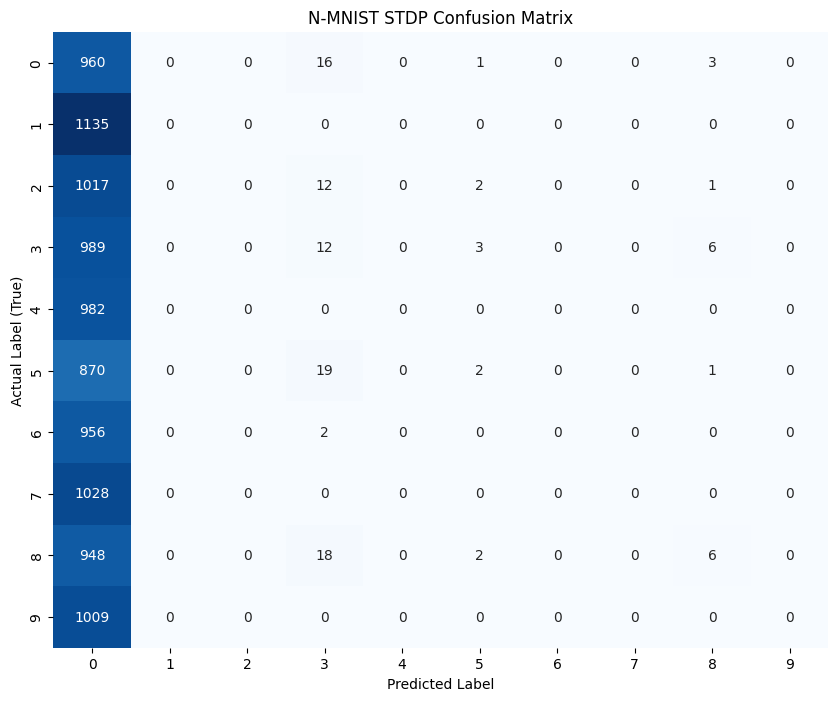

In [132]:
# 1. Ottieni i dati
y_pred, y_true = get_all_predictions(model, test_loader, neuron_labels, C)

# 2. Calcola la matrice
cm = confusion_matrix(y_true, y_pred)

# 3. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label (True)')
plt.title('N-MNIST STDP Confusion Matrix')
plt.show()

In [133]:
# # Prendi un batch dal train loader
# frames, labels = next(iter(train_loader))
# frames = frames.to(device).permute(0, 1, 4, 2, 3)

# # Fai passare i dati (senza training)
# model.eval()
# spike_counts = model.forward_sequence_eval(frames)

# # Statistiche
# total_spikes = spike_counts.sum().item()
# active_neurons = (spike_counts.sum(dim=0) > 0).sum().item()

# print(f"Totale Spike nel Batch: {total_spikes}")
# print(f"Neuroni Attivi (che hanno sparato almeno una volta): {active_neurons} su {C.n_neurons}")

# if active_neurons < 10:
#     print("DIAGNOSI: La rete è ancora morta. I parametri non sono abbastanza aggressivi.")
# else:
#     print("DIAGNOSI: La rete è viva! Il problema è nell'assegnazione delle etichette.")

In [134]:
# # Test rapido attività
# model.eval()
# frames, labels = next(iter(train_loader))
# frames = frames.to(device).permute(0, 1, 4, 2, 3)

# # Conta gli spike totali in un batch
# spike_counts = model.forward_sequence_eval(frames)
# avg_spikes = spike_counts.mean().item()
# max_spikes = spike_counts.max().item()

# print(f"Media spike per neurone nel batch: {avg_spikes:.4f}")
# print(f"Massimo numero di spike di un singolo neurone: {max_spikes}")
# print(f"Neuroni totalmente morti nel batch: {(spike_counts.sum(dim=0) == 0).sum().item()} su {C.n_neurons}")

In [135]:
# import matplotlib.pyplot as plt
# W = model.feature.W.detach().cpu().numpy()
# # show first 16 neurons
# k = min(16, W.shape[0])
# h, w, c = sensor_size
# nrows = int(math.sqrt(k))
# ncols = int(math.ceil(k / nrows))
# fig, axes = plt.subplots(nrows, ncols, figsize=(1.8*ncols, 1.8*nrows))
# axes = np.array(axes).reshape(-1)
# for i in range(k):
#     # W[i] was trained on flattened [C,H,W]; reconstruct from (H,W,C) then to (C,H,W)
#     filt = W[i].reshape(h, w, c).transpose(2, 0, 1)  # [C,H,W]
#     axes[i].imshow(filt.sum(0))
#     axes[i].set_axis_off()
# for j in range(i+1, nrows*ncols):
#     axes[j].set_visible(False)
# plt.suptitle("Learned receptive fields (sum over polarity)")
# plt.tight_layout()
# plt.show()

RUN 2

In [136]:
import numpy as np

# 1. CONTROLLO ETICHETTE NEURONI (neuron_labels)
# Se qui vedi [512, 0, 0, ...], significa che TUTTI i neuroni votano per la classe 0.
# In quel caso, la rete è "collassata" e la funzione di predizione sta facendo il suo lavoro (purtroppo).
counts = torch.bincount(neuron_labels, minlength=10).cpu().numpy()
print("--- DIAGNOSI NEURONI ---")
print(f"Quanti neuroni sono assegnati a ogni cifra (0-9):")
print(counts)

if counts[0] == 512:
    print("🚨 ALLARME: Tutti i neuroni sono assegnati alla classe 0. Il modello è in collasso totale.")
elif counts.max() > 400:
    print("⚠️ ATTENZIONE: C'è un forte sbilanciamento, una classe domina.")
else:
    print("✅ I neuroni sembrano distribuiti bene.")

# 2. CONTROLLO DATI TEST (y_true)
# Controlliamo se il tuo test_loader sta davvero fornendo tutte le 10 cifre.
# Dalla tua immagine sembrava ci fossero solo classe 0 e 1.
print("\n--- DIAGNOSI DATASET TEST ---")
all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.tolist())

unique_labels = np.unique(all_labels)
print(f"Classi presenti nel test set: {unique_labels}")
print(f"Numero totale campioni test: {len(all_labels)}")

if len(unique_labels) < 10:
    print("🚨 ERRORE GRAVE: Il test set non contiene tutte le 10 cifre! Hai filtrato i dati?")
else:
    print("✅ Il test set è completo.")

# 3. CONTROLLO ATTIVITÀ (Spike)
# I neuroni stanno sparando o sono muti?
model.eval()
frames, _ = next(iter(test_loader))
frames = frames.to(device) # Niente permute, giusto?
with torch.no_grad():
    sc = model.forward_sequence_eval(frames)

print("\n--- DIAGNOSI ATTIVITÀ ---")
print(f"Spike totali in un batch di test: {sc.sum().item()}")
if sc.sum().item() == 0:
    print("🚨 ERRORE: La rete è completamente muta (0 spike).")
else:
    print("✅ La rete sta sparando.")

--- DIAGNOSI NEURONI ---
Quanti neuroni sono assegnati a ogni cifra (0-9):
[ 59   0   0 280   0  53   0   0 120   0]
✅ I neuroni sembrano distribuiti bene.

--- DIAGNOSI DATASET TEST ---
Classi presenti nel test set: [0 1 2 3 4 5 6 7 8 9]
Numero totale campioni test: 10000
✅ Il test set è completo.

--- DIAGNOSI ATTIVITÀ ---
Spike totali in un batch di test: 48.0
✅ La rete sta sparando.
